# Assignment 4
### Do three of six.

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/shaveen/understanding_uncertainty/data/mn_police_use_of_force.csv')
df

,response_datetime,problem,is_911_call,primary_offense,subject_injury,force_type,force_type_action,race,sex,age,type_resistance,precinct,neighborhood
0,2016/01/01 00:47:36,Assault in Progress,Yes,DASLT1,NaN,Bodily Force,Body Weight to Pin,Black,Male,20.0,Tensed,1,Downtown East
1,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,Black,Female,27.0,Verbal Non-Compliance,1,Downtown West
2,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,White,Female,23.0,Verbal Non-Compliance,1,Downtown West
3,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West
4,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12920,2021/08/30 21:38:46,Assault in Progress,Yes,ASLT5,NaN,Bodily Force,Joint Lock,White,Female,69.0,NaN,1,Loring Park
12921,2021/08/30 22:32:22,Unwanted Person,Yes,CIC,NaN,Bodily Force,Joint Lock,NaN,NaN,NaN,NaN,1,Cedar Riverside
12922,2021/08/31 12:03:08,Overdose w/All,Yes,FORCE,NaN,Bodily Force,Body Weight Pin,Black,Male,NaN,NaN,3,Seward
12923,2021/08/31 12:52:52,Attempt Pick-Up,No,WT,NaN,Bodily Force,Body Weight Pin,Black,Male,31.0,NaN,4,Camden Industrial


/var/folders/wr/66f4zf893q541yt3pc0dq3_00000gn/T/ipykernel_4212/1937671457.py:40: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(est, label=race)


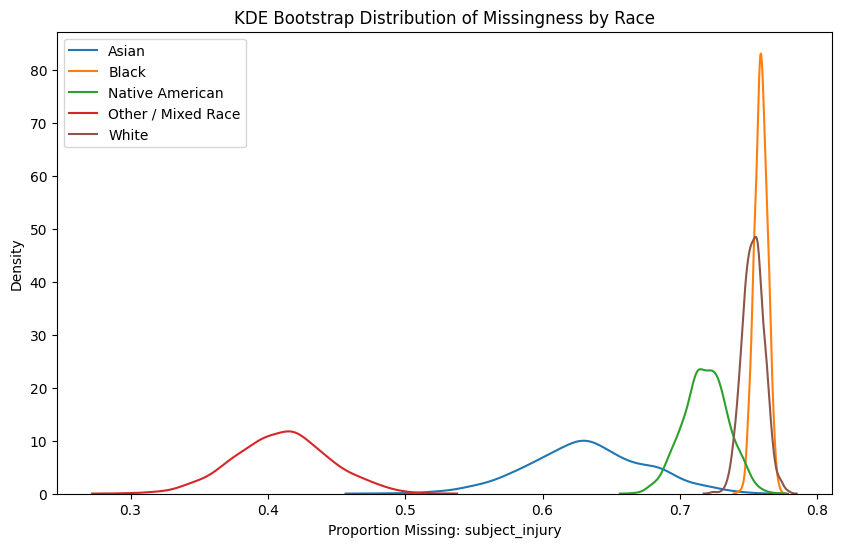

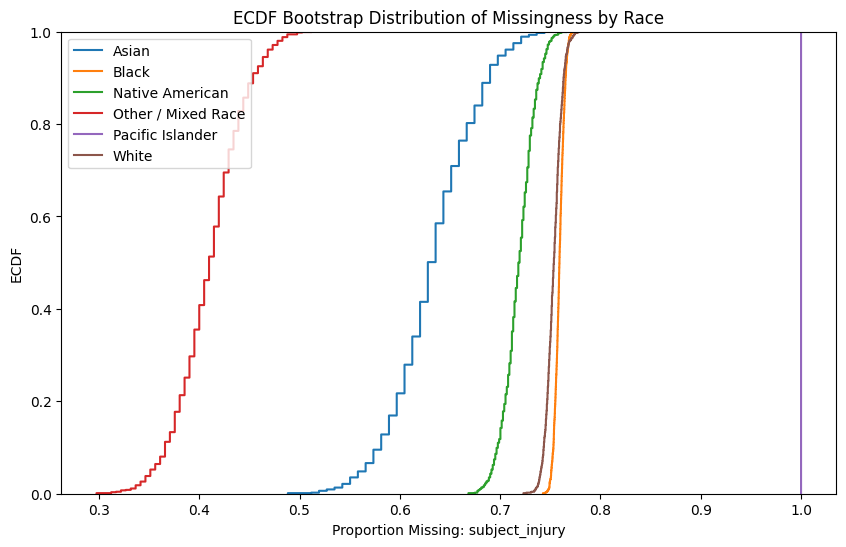

In [2]:
def simulate(var, df, fcn, S=1000, plot=True):  
    x = df[var]

    estimates = []
    for s in range(S):
        x_s = x.sample(frac=1.0, replace=True)
        stat_s = fcn(x_s)
        estimates.append(stat_s)
    estimates = np.array(estimates)

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))
        sns.kdeplot(x, ax=axes[0]).set(title='KDE of Underlying Data')
        sns.kdeplot(estimates, ax=axes[1]).set(title='KDE of Computed Statistics')
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--')
        sns.ecdfplot(estimates, ax=axes[2]).set(title='ECDF of Computed Statistics')
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--')
        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')
    return estimates

# missingness by race
results = {}
for race, g in df.groupby("race"):
    if len(g) == 0:
        continue
    
    estimates = simulate(
        var="subject_injury",
        df=g,
        fcn=lambda x: x.isna().mean(),
        S=1000,
        plot=False
    )
    results[race] = estimates

# KDE
plt.figure(figsize=(10,6))
for race, est in results.items():
    sns.kdeplot(est, label=race)
plt.title("KDE Bootstrap Distribution of Missingness by Race")
plt.xlabel("Proportion Missing: subject_injury")
plt.ylabel("Density")
plt.legend()
plt.show()

# ECDF
plt.figure(figsize=(10,6))
for race, est in results.items():
    sns.ecdfplot(est, label=race)
plt.title("ECDF Bootstrap Distribution of Missingness by Race")
plt.xlabel("Proportion Missing: subject_injury")
plt.ylabel("ECDF")
plt.legend()
plt.show()


From the KDE plot we can see that the proportion of missing values is very different amongst races. We see the highest proportion and lowest variablility of missing values in the curves representing Black and White individuals. We can determine this from the very narrow and steep curves for those races. The curves representing Other/Mixed Race and Asian individuals have much higher variability and lower proportions of missing values as those curves are much more spread out and less steep. However, it is also important to note that the Other/Mixed Race category may encompass a multitude of different racial backgrounds; thus, this specific race category may not be as reliable of a predictor as the other categories.

The ECDF plot shows us very steep slopes for the lines representing Black and White individuals indicating that there is a very high concentration of data within this proportion region. The line representing Other/Mixed Race individuals is significantly to the left of the other lines, indicating that there are lower proprtions of misisng values for Other/Mixed Race individuals compared to the other races. Because this curve has a less steep slope, we can determine that the spread of the proportion of missing values is wider for Other/Mixed Race individuals.

When considering second order uncertainty, the sampling distributions of these proportions are different. We can see that from the KDE plot as the curves are all different in shape, spread and peak. We can also see the difference in the ECDF plot as each line is separated from one another from left to right, and the slopes of all of the lines are fairly different.

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data
- Use the above function `simulate` to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def simulate(var, df, fcn, S=1000, plot=True): # defining the inputs to the function
    ''' Bootstrap simulation code. '''    
    x = df[var] # original data

    estimates = [] # empty list to populate with estimates
    for s in range(S):
        # draw a new sample, with replacement:
        x_s = x.sample(frac=1.0,replace=True)
        # compute estimate using given function and individual sample:
        stat_s = fcn(x_s)
        # append estimate to list:
        estimates.append(stat_s)
    estimates = np.array(estimates) # convert estimates list list to numpy array

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns
        sns.kdeplot(x, ax = axes[0]).set(title='KDE of Underlying Data') # make a kde plot of the original data
        sns.kdeplot(estimates, ax = axes[1]).set(title='KDE of Computed Statistics') # make a kde plot of the estimates
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--') # add a vertical line at the true value
        sns.ecdfplot(estimates, ax = axes[2]).set(title='ECDF of Computed Statistics') # make an ecdf plot of the estimates
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--') # add a second vertical line at the true value
        plt.show() # display the plots
        print(f'Variance of estimates is: {np.var(estimates)}') # display the variance of the estimates
        
    return estimates

In [9]:
df = pd.read_csv('/Users/shaveen/understanding_uncertainty/data/nhanes_data_17_18.csv')

/var/folders/wr/66f4zf893q541yt3pc0dq3_00000gn/T/ipykernel_4212/186120029.py:1: DtypeWarning: Columns (142) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/shaveen/understanding_uncertainty/data/nhanes_data_17_18.csv')


In [10]:
def stat(x):
    stat = np.mean(x)
    return stat

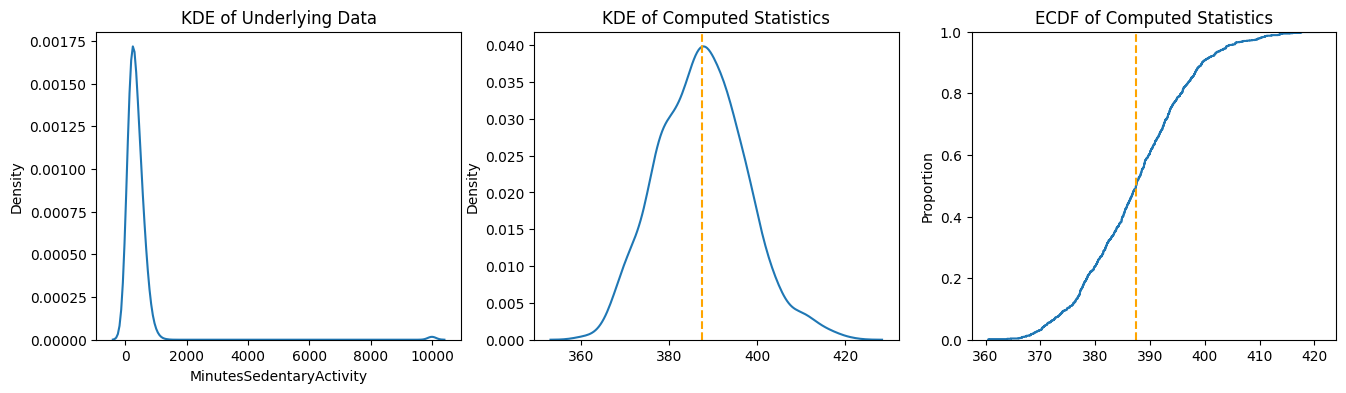

Variance of estimates is: 97.85428020400396


In [11]:
estimates = simulate('MinutesSedentaryActivity',df,stat)

In [12]:
def interval(L,H,estimates):
    L_quantile = np.quantile(estimates,L)
    H_quantile = np.quantile(estimates,H)
    return L_quantile, H_quantile

In [13]:
L,H = interval(0.05,0.95,estimates)
L,H

(np.float64(371.2260100782607), np.float64(403.8891455952881))

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

### Exercise 5
- Extend the `kde` class by adding a method to do bandwidth selection using a simple train-test split
- Extend the `kde` class by adding a method to do bandwidth seleciton by $k$-fold cross validation

### Exercise 6
In this exercise, you're going to do for LCLS what we just did for KDE: Pick the bandwidth 

Recall, the LCLS estimator is
$$
\hat{y}_{N,h}(z) = \dfrac{\frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left(\frac{z-x_i}{h}\right)}{\frac{1}{N} \sum_{i=1}^N \frac{1}{h}k\left(\frac{z-x_i}{h} \right)}.
$$
- Select two numeric variables from a data set. Split the data into training and test sets.
- Write a `predict(X_{train},Y_{train},X_{train})` function/method that takes a set of values $X_{test}$ and data $(X_{train},Y_{train})$, and computed predicted values $\hat{y}(X_{test})$ 
- Write a function/method that selects the bandwidth by **minimizing** the **mean squared error** of the squared differences between $\hat{y}(x_j)$ and $y_j$ on the test set:
$$
MSE(h) = \frac{1}{N_{test}} \sum_{j=1}^{N_{test}} (y_j - \hat{y}_{N_{train},h}(x_j))^2
$$
Be sure you understand what's happening here: The training data are used to make predictions for each test observation $x_j$, and then the prediction $\hat{y}(x_j)$ and true value $y_j$ are compared using squared difference